# RUL prediction: Practice

# Libs

In [9]:
import os
import re
import sys
import pandas as pd
import numpy as np

#to plot the data
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

import time   
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import minmax_scale
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.utils import class_weight

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
 
from fitter import Fitter, get_common_distributions, get_distributions

from collections import Counter
import missingno as mn 
import random
from copy import deepcopy 

from sklearn import ensemble 
from sklearn import tree  
from sklearn import kernel_ridge

from sklearn.preprocessing import scale

from sklearn import linear_model 
from sklearn import decomposition
from sklearn import svm 
import catboost  
import lightgbm 

from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error 
from sklearn.model_selection import RepeatedKFold
from sklearn import model_selection

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV 

from scipy.stats import pearsonr 
from dtaidistance import dtw, dtw_ndim
from kneed import DataGenerator, KneeLocator
from  sklearn.feature_selection import VarianceThreshold

from statsmodels.tsa.stattools import adfuller 
from scipy.fft import fft, ifft
from IPython.display import display, Markdown, Image

%matplotlib inline

import warnings
warnings.simplefilter("ignore")

In [6]:
#!pip install catboost lightgbm dtaidistance kneed --upgrade 

# Load Data

In [12]:
current = os.getcwd() 
parent_folder = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
 
PROJECT_PATH = os.getcwd() + "/gifs"  
current = os.getcwd() 
parent_folder = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

sys.path.insert(0, f"{parent_folder}\Classes") # 
from menu_A_a_data_utility import DataUtility 
#from memu_D_features import SelectingEDAFeatures

In [19]:
def load_data(flags = None):
    uti = DataUtility()
    df_train, df_test, df_result = uti.prepare_dfs()
    df_train["rul"] = df_train.groupby(["Flag","id"])["cycle"].transform("max")-df_train["cycle"]
    
    if not flags:
        return df_train, df_test, df_result
    if type(flags) == str:
        flags = [flags] #list 
    return df_train[df_train["Flag"].isin(flags)],df_test[df_test["Flag"].isin(flags)],df_result[df_result["Flag"].isin(flags)]

DF_TRAIN, DF_TEST, DF_RESULT = load_data(flags = "FD001") 

In [15]:
train, _, _ = load_data("FD002")

In [18]:
train.shape, train["id"].nunique()

((53759, 28), 260)

# Define "Output" -- RUL
* visualize rul distributions and test it. 

## Life Time

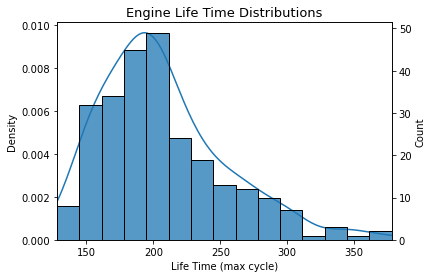

In [20]:

tmp = train.copy()
tmp = train.groupby("id")["cycle"].max().reset_index()

fig, ax1 = plt.subplots()
kde_data = sns.kdeplot(data=tmp, x="cycle", ax=ax1)

ax1.set_xlim((tmp["cycle"].min(), tmp["cycle"].max()))
ax2 = ax1.twinx()

sns.histplot(data=tmp, x="cycle", discrete=False, ax=ax2)
plt.grid(False)
plt.title("Engine Life Time Distributions", fontsize=13)
ax1.set_xlabel("Life Time (max cycle)")
plt.show()

In [27]:
def plot(flags = None, show_fig = True): 
    plt.ioff()
    if not flags:
        flags = "FD001"
    DF_TRAIN, _, _ = load_data(flags = flags ) 
    
    tmp = DF_TRAIN.copy()
    tmp = DF_TRAIN.groupby("id")["cycle"].max().reset_index()

    fig, ax1 = plt.subplots()
    kde_data = sns.kdeplot(data=tmp, x="cycle", ax=ax1)

    ax1.set_xlim((tmp["cycle"].min(), tmp["cycle"].max()))
    ax2 = ax1.twinx()

    sns.histplot(data=tmp, x="cycle", discrete=False, ax=ax2)
    plt.grid(False)
    plt.title("Engine Life Time Distributions", fontsize=13)
    ax1.set_xlabel("Life Time (max cycle)")
    if show_fig: 
        plt.show()
    
    return kde_data
    

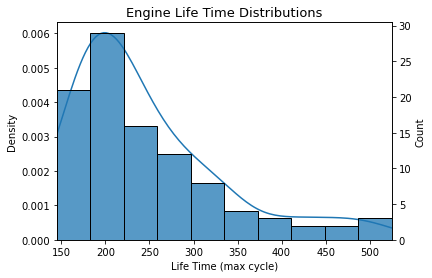

In [24]:
plot(flags = "FD003")

## check distribution

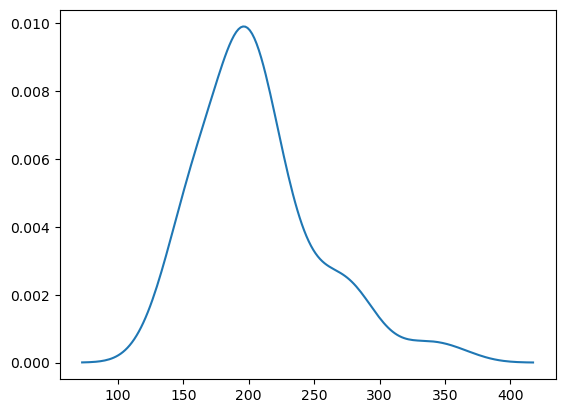

In [8]:
line = kde_data.lines[0]
x, y = line.get_data() 
fig, ax = plt.subplots()
ax.plot(x[x>0], y[x>0]) 
plt.show()

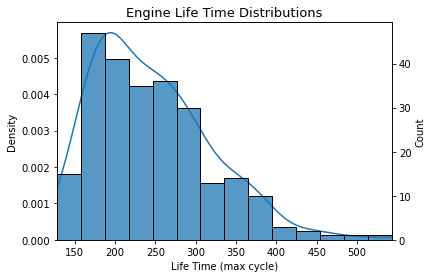

In [26]:
kde_data = plot("FD004")
line = kde_data.lines[0]
x, y = line.get_data() 

Fitting 5 distributions: 100%|███████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.21it/s]


{'gamma': {'a': 0.61763270210712,
  'loc': 7.339891161774741e-07,
  'scale': 0.0011379817391219608}}

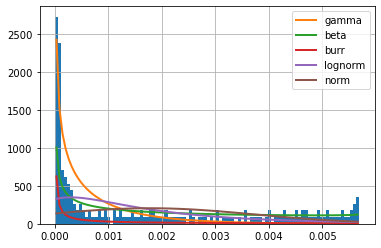

In [28]:
f = Fitter(y,
           distributions=['gamma',
                          'lognorm',
                          "beta",
                          "burr",
                          "norm"])
f.fit()
f.summary() 
f.get_best(method = 'sumsquare_error') 

**lognorm:**
* In reliability analysis, the log-normal distribution is often used to model times to repair a maintainable system
* The length of comments posted in Internet discussion forums follows a log-normal distribution

In [14]:
def load_data(flags = None):
    uti = DataUtility()
    df_train, df_test, df_result = uti.prepare_dfs()
    df_train["rul"] = df_train.groupby(["Flag","id"])["cycle"].transform("max")-df_train["cycle"]
    
    if not flags:
        return df_train, df_test, df_result
    if type(flags) == str:
        flags = [flags] #list 
    return df_train[df_train["Flag"].isin(flags)],df_test[df_test["Flag"].isin(flags)],df_result[df_result["Flag"].isin(flags)]

DF_TRAIN, DF_TEST, DF_RESULT = load_data(flags = "FD001")  

# Round One: Model Features

## wrap up

In [31]:
#%%writefile memu_D_features.py

from  sklearn.feature_selection import VarianceThreshold
from collections import Counter
from copy import deepcopy 
from dtaidistance import dtw, dtw_ndim
from fitter import Fitter, get_common_distributions, get_distributions
from IPython.display import display, Markdown, Image
from kneed import DataGenerator, KneeLocator
from scipy.fft import fft, ifft
from scipy.stats import pearsonr 
from sklearn import decomposition
from sklearn import ensemble 
from sklearn import kernel_ridge
from sklearn import linear_model 
from sklearn import model_selection
from sklearn import svm 
from sklearn import tree  
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error 
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import scale
from sklearn.utils import class_weight
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.stattools import adfuller 
import catboost  
import lightgbm 
import matplotlib as mpl
import matplotlib.pyplot as plt
import missingno as mn 
import numpy as np
import os
import pandas as pd
import random
import re
import seaborn as sns
import sys
import time   
import warnings

class SelectingEDAFeatures(object):
    def __init__(self, per_missing=0.50, dominant_threshold= 0.95, \
                dispersion_threshold=(1-1.0e-9, 1+1.0e-9), heat_map_threshold = 0.9,\
                max_vif=9): 
        """
            documentation: 
            set thresholds
        """ 
        self.per_missing = per_missing  
        self.dominant_threshold = dominant_threshold
        self.dispersion_threshold = dispersion_threshold
        self.all_feature_columsn = [col for col in list(DF_TRAIN) if re.match("(op|sen)", col)]
        self.heat_map_threshold = heat_map_threshold
        self.max_vif = max_vif
    
    def eda_features(self):
        """
            doc:
            output: conduct exploration and summarize
        """
    def indentify_missing(self):
        """
            documentation: 
            identify missing
            missingno
        """ 
        tmp = DF_TRAIN.copy()  
        #masks = np.random.choice([True, False], size=tmp.shape, p = [p, 1-p])
        #tmp = tmp.mask(masks)    
        return np.array(list(tmp))[tmp.isnull().sum(axis=0)/tmp.shape[0] > self.per_missing]

    def dominant(self, x, per): 
        """
            documentation: 
            helper fun
        """ 
        return Counter(x).most_common(1)[0][1]/len(x) > per

    def identify_constants(self):
        """
            documentation: 
            identify constants
        """ 
        tmp = DF_TRAIN.copy()
        tmp = tmp.select_dtypes(include = "number")
        tmp.drop(columns = ["id", "cycle", "rul"], inplace = True)

        feats =  list(tmp)

        # compare it in two way: threshold = 0  
        vt = VarianceThreshold(threshold=0) #恒值
        _ = vt.fit_transform(tmp)
        kept_columns = vt.get_feature_names_out() 

        consts = [c for c in feats if c not in kept_columns] 

        # dominant values doesn't account for per%   
        quasi_columns = np.array(list(tmp))[tmp.apply(lambda x: self.dominant(x, self.dominant_threshold))]

        return list(set(consts + list(quasi_columns))) 
        #ROUNDONE_CONST = round_one_remove_low_variance()  
                 
    def plot_columns(self):
        """
            documentation: 
            plotting
        """ 
        tmp = DF_TRAIN.copy()
        tmp = tmp.select_dtypes(include = "number")
        tmp.drop(columns = ["id", "cycle", "rul"], inplace = True) 
        tmp.hist(bins=30, figsize=(15, 10),   layout=(-1, 4) ) 
        plt.tight_layout()
        plt.show()

    def dispersion(self,data): 
        """
            documentation: 
            dispersions. 
            return flat cols and dispersion values 
        """ 
        arith_mean = np.mean(data+1, axis =0 )
        #geo_mean = np.power(np.prod(data, axis =0 ),1/data.shape[0]) 
        geo_mean = sum(np.log1p(data))/len(data)
        geo_mean = np.exp(geo_mean) 
        return arith_mean/geo_mean  

    def identify_flat_dispersion(self):
        tmp = DF_TRAIN.copy()
        tmp = tmp.select_dtypes(include = "number")
        tmp.drop(columns = ["id", "cycle", "rul"], inplace = True)

        dispersions = tmp.apply(lambda x: self.dispersion(x), axis=0)
        criteria = np.where(np.logical_and(dispersions>self.dispersion_threshold[0], \
                                           dispersions<self.dispersion_threshold[1]))
        low_dispersion = np.array(list(tmp))[criteria]
        return low_dispersion, dispersions
        #dispersions = np.array(list(tmp))[tmp.apply(lambda x: dispersion(x), axis=0)>threshold]  
        #ROUNDONE_DISPERSION, _  = filter_by_dispersion(threshold=thresholds)
        
    def plot_by_id_corner(self, ids = [12,76], n_cols =5, pre_filtered_cols = None):
        """
            documentation: 
            plotting corr
        """ 
        if not pre_filtered_cols:
            pre_filtered_cols = self.cols_for_plotting()

        tmp = DF_TRAIN.copy()  
        tmp = tmp[tmp["id"].isin(ids)]

        max_rul = tmp["rul"].max()
        for id_engine in ids:
            if max_rul > tmp[tmp["id"]==id_engine]["rul"].max():
                max_rul = tmp[tmp["id"]==id_engine]["rul"].max()
        tmp = tmp[tmp["rul"]<=max_rul]  
  
        cols = random.sample(pre_filtered_cols, n_cols)
 
        cols.append("rul") 

        # seaborn matplotlib
        g = sns.PairGrid(tmp, vars = cols,diag_sharey = False, corner = True, hue = 'id' ) 
        g.map_lower(plt.scatter, alpha=0.6)
        #g.map_diag(plt.hist, alpha=0.7 ) 
        g.map_diag(sns.kdeplot)

        plt.show()   
        #plot_by_id_corner()
    
    def plot_by_id_pair(self, ids = [2,76], n_cols =5, pre_filtered_cols = None):
        """
            documentation: 
            plotting corr
        """         
        sns.set_style("whitegrid") 
        
        if not pre_filtered_cols:
            pre_filtered_cols = self.cols_for_plotting()

        tmp = DF_TRAIN.copy()  
        tmp = tmp[tmp["id"].isin(ids)]

        max_rul = tmp["rul"].max()
        for id_engine in ids:
            if max_rul > tmp[tmp["id"]==id_engine]["rul"].max():
                max_rul = tmp[tmp["id"]==id_engine]["rul"].max()
        tmp = tmp[tmp["rul"]<=max_rul]  

        cols = random.sample(pre_filtered_cols, n_cols) 
        cols.append("rul") 

        sns.pairplot(tmp, vars=cols, diag_kind = 'kde', hue="id")

        plt.show()   
        #plot_by_id_pair()

    def plot_by_id_strip(self, ruls=None, n_feat=5, pre_filtered_cols=None):
        """
            documentation: 
            plotting corr
        """         
        sns.set_style("whitegrid") 
        
        if not pre_filtered_cols:
            pre_filtered_cols = self.cols_for_plotting() 

        tmp = DF_TRAIN.copy() 

        if not ruls:
            ruls = [i for i in range(1, tmp["rul"].max(), 50)]

        tmp = tmp[tmp["rul"].isin(ruls)]

        cols = random.sample(pre_filtered_cols, n_feat)  

        sns.stripplot(data=tmp, y="sensor21", x="rul",  dodge=True, jitter=False,  palette="deep")

        plt.show()   
        return tmp    
    
    def cols_for_plotting(self):
        """
            doc:
            helper function
        """
        constant_cols = self.identify_constants() 
        return [c for c in self.all_feature_columsn if c not in constant_cols] 
    
    def heatmap_plot(self, show_fig=True, pre_filtered_cols=None ):
        """
            doc:
            return high corr cols
        """  
        if not pre_filtered_cols:
            pre_filtered_cols = self.cols_for_plotting()
            
        tmp = DF_TRAIN.copy()  
        tmp_corr = tmp[pre_filtered_cols].corr(method="pearson")
        
        if show_fig:
            plt.figure(figsize=(9, 9))

            ax = sns.heatmap(tmp_corr,  square=True, annot=True,annot_kws={"size": 8},
                        center=0, fmt=".2f",   linewidths=.5,  #fmt=".2g",
                        cmap="vlag", cbar_kws={"shrink": 0.8});

            ax.xaxis.tick_top()
            #sns.set(font_scale=1)
            plt.xticks(rotation = 90)
            plt.show()
  
        colss = list(tmp_corr)
        ln = len(tmp_corr)  
        allvals = tmp_corr.values
        pairs = []
        for i in range(ln):
            for j in range(i+1, ln):
                if abs(allvals[i, j])>self.heat_map_threshold:
                    pairs.append((colss[i], colss[j], allvals[i, j]))
        return pairs
 
    def filter_by_val(self, feats):   # 9.0 is conventional chosen 
        """
            doc:
            return high corr cols
        """   
        ss = StandardScaler() # Normalizer, RobustScaler, minmax_scale
        tmp = DF_TRAIN.copy()   
        tmp = tmp[feats]  

        ss_tmp = ss.fit_transform(tmp) 

        ss_tmp = pd.DataFrame(ss_tmp, columns=list(tmp)) 
        vif_data = pd.DataFrame()
        vif_data["feature"] = ss_tmp.columns

        vif_data["VIF"] = [variance_inflation_factor(ss_tmp.values, i) for i in range(len(ss_tmp.columns))]

        return list(vif_data["feature"]), vif_data  
  
    def identify_high_vif_columns(self, pre_filtered_cols=None):
        """
            doc:
            return high corr cols from VIF
            return 
        """  
        if not pre_filtered_cols:
            pre_filtered_cols = self.cols_for_plotting()
            
        tmp = DF_TRAIN.copy()   
        val = np.inf
        rounds = 0 
        max_rounds = tmp.shape[1]
        
        feats = deepcopy(pre_filtered_cols) 
        high_vif_col = [] 
    
        while val > self.max_vif:  
            rounds += 1  
            feats, df_vals = self.filter_by_val(feats=feats) 
      
            max_row = df_vals.loc[df_vals["VIF"].idxmax()]

            feat, val = max_row[0], max_row[1]

            if val < self.max_vif:
                return list(feats), high_vif_col 
            else: 
                feats.remove(feat)
                high_vif_col.append(feat)
            if rounds>max_rounds:
                break
        return feats, high_vif_col
        
    def eda_features(self):
        """
            doc:
            output: conduct exploration and summarize
        """
        missing = self.indentify_missing()
        const = self.identify_constants()
        flats, _ = self.identify_flat_dispersion()
        _, vif = self.identify_high_vif_columns()
        
        to_remove = list(missing) + list(const) + list(flats) + list(vif) 
      
        return [c for c in self.all_feature_columsn if c not in to_remove]
    
        


In [32]:
fs = SelectingEDAFeatures()
FEATS = fs.eda_features()
# vif 
vif_cols = fs.identify_high_vif_columns()

In [14]:
FEATS

['op1',
 'op2',
 'sensor2',
 'sensor3',
 'sensor4',
 'sensor7',
 'sensor11',
 'sensor12',
 'sensor14',
 'sensor15',
 'sensor17',
 'sensor20',
 'sensor21']

# Round Two: Follow the book 

## Wrap up 

In [15]:
#%%writefile memu_D_features_reserve.py
from  sklearn.feature_selection import VarianceThreshold
from collections import Counter
from copy import deepcopy 
from dtaidistance import dtw, dtw_ndim
from fitter import Fitter, get_common_distributions, get_distributions
from IPython.display import display, Markdown, Image
from kneed import DataGenerator, KneeLocator
from scipy.fft import fft, ifft
from scipy.stats import pearsonr 
from sklearn import decomposition
from sklearn import ensemble 
from sklearn import kernel_ridge
from sklearn import linear_model 
from sklearn import model_selection
from sklearn import svm 
from sklearn import tree  
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error 
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import scale
from sklearn.utils import class_weight
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.stattools import adfuller 
import catboost  
import lightgbm 
import matplotlib as mpl
import matplotlib.pyplot as plt
import missingno as mn 
import numpy as np
import os
import pandas as pd
import random
import re
import seaborn as sns
import sys
import time   
import warnings

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from matplotlib import pyplot
from sklearn.feature_selection import RFECV
from sklearn.svm import SVR 
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel 

class FeatureSelection(object):
    def __init__(self, random_state=123, test_size=0.3, features = None):
        """
            documentation: 
            this module will be explained and utilized later for Classification
        """ 
        self.test_size = test_size
        self.random_state = random_state 
        self.features = features
        
    def split_df(self, df): 
        """
            doc: 
            this module will be explained and utilized later for Classification
        """ 
        Y = df["rul"]
        X = df[self.feats]
        return train_test_split(X,Y, test_size=self.test_size, random_state=self.random_state)

    def select_features(self, df, to_plot=True):  
        """
            doc: 
            this module will be explained and utilized later for Classification
        """ 
        fs = SelectKBest(score_func=f_regression, k="all")
        # learn relationship from training data
        fs.fit(X_train, y_train)
        # transform train input data
        X_train_fs = fs.transform(X_train)
        # transform test input data
        X_test_fs = fs.transform(X_test)
        
        if to_plot: 
            # what are scores for the features
            for i in range(len(fs.scores_)):
                print('Feature %d: %f' % (i, fs.scores_[i]))
            # plot the scores
            sns.barplot([i for i in range(len(fs.scores_))], fs.scores_) 
            plt.show() 
        return X_train_fs, X_test_fs, fs
    
    def wrapping(self, df, y):  
        """
            doc: 
            this module will be explained and utilized later for Classification
        """ 
        estimator = SVR(kernel="linear") 
        selector = RFECV(estimator, step=1, cv=5)
        selector = selector.fit(df, y)
        #selector.support_ 
        #selector.ranking_ 
        return selector

    def embedded(self, df): 
        scaler = StandardScaler()
        scaler.fit(tmp) 
        sel_ = SelectFromModel(Lasso(alpha=1)) # lambda 
        sel_.fit(scaler.transform(df), y) 
        #sel_.estimator_.coef_ 
        #sel_.threshold_
        #sel_.get_support() 
        return sel_


# Problem Revisit
* RUL

## rul distribution

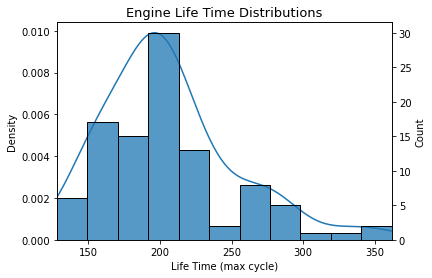

In [9]:
tmp = DF_TRAIN.copy()
tmp = DF_TRAIN.groupby("id")["cycle"].max().reset_index()
 
fig, ax1 = plt.subplots()
kde_data = sns.kdeplot(data=tmp, x="cycle", ax=ax1)
ax1.set_xlim((tmp["cycle"].min(), tmp["cycle"].max()))
ax2 = ax1.twinx()
sns.histplot(data=tmp, x="cycle", discrete=False, ax=ax2)
plt.grid(False)
plt.title("Engine Life Time Distributions", fontsize=13)
ax1.set_xlabel("Life Time (max cycle)")
plt.show()

## predict rul

In [17]:
FEATS = fs.eda_features()

tmp = DF_TRAIN.copy()
tmp[FEATS].head(2)
# lognorm

,op1,op2,sensor2,sensor3,sensor4,sensor7,sensor11,sensor12,sensor14,sensor15,sensor17,sensor20,sensor21
0,-0.0007,-0.0004,641.82,1589.70,1400.60,554.36,47.47,521.66,8138.62,8.4195,392,39.06,23.4190
1,0.0019,-0.0003,642.15,1591.82,1403.14,553.75,47.49,522.28,8131.49,8.4318,392,39.00,23.4236


In [18]:
fs = SelectingEDAFeatures()
FEATS = fs.eda_features()

In [32]:
import numpy as np
from sklearn import datasets, linear_model, metrics
from sklearn.metrics import  mean_squared_error, r2_score
random_state = 123   

def lin_train_rul(tmp, output_col = None, last_only = True): 
    #FEATS= round_one_final() 
    
    if not output_col:
        y = tmp.pop("rul")
    else: 
        y = tmp.pop(output_col) 
        
    X = tmp[FEATS]

    ss = MinMaxScaler() 
     
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=random_state)
    
    if last_only:
        X_test = DF_TEST.copy()
        X_test = X_test.drop('cycle', axis=1).groupby('id').last().copy().reset_index()# get last row of each engine 
        y_test = X_test['remaining_rul'].copy()
        X_test = X_test[FEATS] 
         
    X_train = pd.DataFrame(ss.fit_transform(X_train))
    X_train.columns = FEATS

    X_test = pd.DataFrame(ss.transform(X_test))
    X_test.columns = FEATS 

    # create linear regression object
    reg = linear_model.LinearRegression(fit_intercept=False) 
    # train the model using the training sets
    reg.fit(X_train, y_train )

    # regression coefficients
    print('Coefficients: ', reg.coef_)

    # variance score: 1 means perfect prediction
    print('Variance score: {}'.format(reg.score(X_test, y_test)))

    # plot for residual error  
    ## setting plot style
    plt.style.use('fivethirtyeight')

    ## plotting residual errors in training data
    plt.scatter(reg.predict(X_train), reg.predict(X_train) - y_train,
                color = "green", s = 10, label = 'Train data')

    ## plotting residual errors in test data
    predictions = reg.predict(X_test) 
    plt.scatter(predictions, predictions - y_test,
                color = "blue", s = 10, label = 'Test data')

    ## plotting line for zero residual error
    xmax = max(predictions) 
    
    plt.hlines(y = 0, xmin = 0, xmax = xmax, linewidth = 2)

    ## plotting legend
    plt.legend(loc = 'upper left') 
    ## plot title
    plt.title("Residual errors") 
    ## method call for showing the plot
    plt.show()
    
    r2 = r2_score(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    pearsonr = np.corrcoef(np.array(y_test), np.array(predictions))
    return  reg.coef_, predictions, X_train, FEATS,  r2, mse, pearsonr

Coefficients:  [   7.26250398    5.07398333   -3.97665083   -6.23020036  -17.86041646
   78.13633697  -28.88410802   99.16566293 -123.47479179  -13.05998067
   -1.82110431   55.73362489   52.88035788]
Variance score: 0.3849596502920525


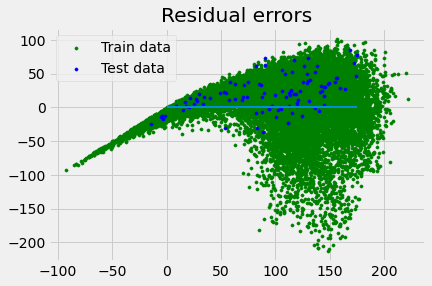

In [33]:
tmp = DF_TRAIN.copy()
_, predictions, _, _, r2, mse, pearsonr = lin_train_rul(tmp = tmp)

# Regression models: a comprehensive list

In [4]:
FEATS = ['op1',
 'op2',
 'sensor2',
 'sensor3',
 'sensor4',
 'sensor7',
 'sensor8',
 'sensor11',
 'sensor12',
 'sensor13',
 'sensor14',
 'sensor15',
 'sensor17',
 'sensor20',
 'sensor21']

In [5]:
def prepare(random_state = 123):
    tmp = DF_TRAIN.copy()
    X = tmp[FEATS] 
    y = tmp.pop("rul") 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=random_state)
    return X_train, X_test, y_train, y_test

* linear reg

In [30]:
from sklearn import linear_model
reg = linear_model.LinearRegression(fit_intercept=True) 
reg.fit(X_train, y_train) 

predictions = reg.predict(X_test)
r2 = r2_score(y_test, predictions) 
mse = mean_absolute_error( y_test, predictions)
r2, mse, reg.coef_

(0.5717578899081595,
 34.550372946477246,
 array([-1.16503705e+02,  2.17927030e+03, -5.58470905e+00, -4.76883740e-01,
        -7.81227522e-01,  6.05390672e+00, -1.12841090e+01, -3.83718625e+01,
         1.13002585e+01, -1.80985275e+01, -6.69849454e-01, -1.27265418e+02,
        -1.77472626e+00,  2.30102074e+01,  4.34351929e+01]))

* LassoLars

In [71]:
from sklearn import linear_model
reg = linear_model.LassoLars(alpha=.1, normalize=False)
reg.fit(X_train, y_train) 

predictions = reg.predict(X_test)
r2 = r2_score(y_test, predictions) 
mse = mean_absolute_error( y_test, predictions)
r2, mse, reg.coef_

(0.5703402343505695,
 34.58987999059144,
 array([  0.        ,   0.        ,  -6.67250055,  -0.61201974,
         -1.02119579,   7.81275644,   0.        , -40.39803671,
         13.82198983,   0.        ,  -0.65105249,   0.        ,
         -2.31899146,  20.42295018,  26.90840273]))

* Ridge

In [73]:
reg = linear_model.Ridge(alpha=.5) 
reg.fit(X_train, y_train)  
predictions = reg.predict(X_test)
r2 = r2_score(y_test, predictions) 
mse = mean_absolute_error( y_test, predictions)
r2, mse, reg.coef_

(0.5718929232799095,
 34.545020746860914,
 array([ -11.75549457,    4.57537319,   -5.65275632,   -0.4798882 ,
          -0.78906327,    6.12241778,  -11.70441106,  -38.5886947 ,
          11.38580344,  -18.06812031,   -0.67125703, -116.58631706,
          -1.78856513,   23.11514555,   43.31601452]))

* bayesian <br>
Bayesian linear regression is a form of regression analysis technique used in machine learning that uses Bayes' theorem to calculate the regression coefficients' values. Rather than determining the least-squares, this technique determines the features' posterior distribution. As a result, the approach outperforms ordinary linear regression in terms of stability.Bayesian linear regression is a form of regression analysis technique used in machine learning that uses Bayes' theorem to calculate the regression coefficients' values. Rather than determining the least-squares, this technique determines the features' posterior distribution. As a result, the approach outperforms ordinary linear regression in terms of stability.

In [75]:
reg = linear_model.BayesianRidge()   
reg.fit(X_train, y_train)  
predictions = reg.predict(X_test)
r2 = r2_score(y_test, predictions) 
mse = mean_absolute_error( y_test, predictions)
r2, mse, reg.coef_

(0.5718814311340489,
 34.542581211122986,
 array([ -3.63677664,   1.28553115,  -5.77769076,  -0.48825218,
         -0.80420206,   6.26161541, -12.40231807, -38.87495113,
         11.58826815, -17.97630194,  -0.67389004, -96.44038357,
         -1.83201373,  23.33892431,  42.7361165 ]))

* Generalized Linear Model

In [79]:
reg = linear_model.TweedieRegressor(power=1, alpha=0.5, link='log')   
reg.fit(X_train, y_train)  
predictions = reg.predict(X_test)
r2 = r2_score(y_test, predictions) 
mse = mean_absolute_error( y_test, predictions)
r2, mse, reg.coef_

(-0.000233535648204386,
 57.068808187319355,
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

* poly nomial

In [31]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
import numpy as np
model = Pipeline([('poly', PolynomialFeatures(degree=3)), ('linear', LinearRegression(fit_intercept=False))]) 
 
model = model.fit(X_train, y_train)
model.named_steps['linear'].coef_

predictions = model.predict(X_test)
r2 = r2_score(y_test, predictions) 
mse = mean_absolute_error( y_test, predictions)
r2, mse, model["linear"].coef_[:2]

(0.604769728948796, 31.9306847403501, array([2.02585659e+02, 4.30279227e-02]))

* QuantileRegressor --- very slow

In [ ]:
reg = linear_model.QuantileRegressor(quantile=0.5, alpha=0)    
reg.fit(X_train, y_train)  
predictions = reg.predict(X_test)
r2 = r2_score(y_test, predictions) 
mse = mean_absolute_error( y_test, predictions)
r2, mse, reg.coef_

* OMP

In [32]:
reg = linear_model.OrthogonalMatchingPursuit(normalize=False).fit(X, y)   
reg.fit(X_train, y_train)  
predictions = reg.predict(X_test)
r2 = r2_score(y_test, predictions) 
mse = mean_absolute_error( y_test, predictions)
r2, mse, reg.coef_

(0.4560704404555609,
 39.4177479151354,
 array([ 0.       ,  0.       ,  0.       ,  0.       , -5.1903585,
         0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0.       ,  0.       ]))

* logit

In [34]:
regi = linear_model.LogisticRegression(penalty='l2')
reg.fit(X_train, y_train)  
predictions = reg.predict(X_test)
r2 = r2_score(y_test, predictions) 
mse = mean_absolute_error( y_test, predictions)
r2, mse, reg.coef_

(0.4560704404555609,
 39.4177479151354,
 array([ 0.       ,  0.       ,  0.       ,  0.       , -5.1903585,
         0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0.       ,  0.       ]))

* SGD

In [ ]:
reg = linear_model.SGDRegressor(loss='squared_error',   penalty='l2')  
reg.fit(X_train, y_train)  
predictions = reg.predict(X_test)
r2 = r2_score(y_test, predictions) 
mae = mean_absolute_error( y_test, predictions)
mse = mean_squared_error( y_test, predictions)
r2, mae, reg.coef_ , mse

* PassiveAggressiveRegressor
`are a family of algorithms for large-scale learning`

In [37]:
reg = linear_model.PassiveAggressiveRegressor(max_iter=100, random_state=0, tol=1e-3)
reg.fit(X_train, y_train)  
predictions = reg.predict(X_test)
r2 = r2_score(y_test, predictions) 
mse = mean_absolute_error( y_test, predictions)
r2, mse, reg.coef_


(0.4396722611334192,
 40.12515903613922,
 array([-2.66678001e-05,  7.25088817e-07,  1.61802475e-01, -1.33668057e+00,
        -2.83578795e+00,  6.88644339e-01,  1.31702272e+00, -9.56951565e-02,
         6.16983738e-01,  1.31661790e+00, -8.80255505e-02, -1.11415478e-02,
        -3.95604578e-01,  9.70938790e-02,  5.85344433e-02]))

* robust

In [54]:
lr = linear_model.LinearRegression()
lr.fit(X_train, y_train)

X,y = X_train.values, y_train.values
# Robustly fit linear model with RANSAC algorithm
ransac = linear_model.RANSACRegressor()
ransac.fit(X, y) 

predictions = ransac.predict(X_test)
r2 = r2_score(y_test, predictions) 
mse = mean_absolute_error( y_test, predictions)
r2, mse 
 

(0.3424253423110277, 42.73620117155814)

* elastic model

In [62]:
reg = linear_model.ElasticNet(alpha=0.5)
reg.fit(X_train, y_train)  
predictions = reg.predict(X_test)
r2 = r2_score(y_test, predictions) 
mse = mean_absolute_error( y_test, predictions)
r2, mse, reg.coef_
 

(0.5527274073405888,
 35.356029964683195,
 array([-0.        ,  0.        , -4.48782098, -1.34554266, -2.30492111,
         7.8218061 , -0.        , -3.54031339,  8.47016134, -0.        ,
        -0.61163027, -0.        , -4.36971552,  1.74928615,  0.73629206]))

* lasso

In [49]:
reg = linear_model.Lasso(alpha=0.1)
reg.fit(X_train, y_train)  
predictions = reg.predict(X_test)
r2 = r2_score(y_test, predictions) 
mse = mean_absolute_error( y_test, predictions)
r2, mse, reg.coef_ 

(0.570340007762357,
 34.589907740337345,
 array([ -0.        ,   0.        ,  -6.66847336,  -0.61183543,
         -1.02158297,   7.82014008,  -0.        , -40.415231  ,
         13.81801591,  -0.        ,  -0.65108889,  -0.        ,
         -2.31776092,  20.4044511 ,  26.87852948]))

* SVR

In [65]:
from sklearn.svm import SVR
# Epsilon-Support Vector Regression
reg = SVR(C=1.0, epsilon=0.2) # C: l1 or l2 penalty
# epsilon; Epsilon in the epsilon-SVR model. It specifies the epsilon-tube within
# which no penalty is associated in the training loss function with points predicted within a distance epsilon from the actual value.
reg.fit(X_train, y_train)  
predictions = reg.predict(X_test)
r2 = r2_score(y_test, predictions) 
mse = mean_absolute_error( y_test, predictions)
r2, mse 
 

(-0.008399729377851939, 57.00613473893578)

In [67]:
predictions

array([101.80204823, 101.68857293, 101.76745079, ..., 101.79541261,
       101.8145923 , 101.71052907])

In [68]:
# cat boost

In [23]:
import catboost

In [43]:
reg = catboost.CatBoostRegressor(loss_function="RMSE")
y_train = y_train.clip(upper=150)
reg.fit(X_train, y_train)  
predictions = reg.predict(X_test)
r2 = r2_score(y_test, predictions) 
#mse = mean_absolute_error( y_test, predictions)
 

Learning rate set to 0.060928
0:	learn: 47.9628003	total: 5.88ms	remaining: 5.87s
1:	learn: 46.0881193	total: 9.41ms	remaining: 4.7s
2:	learn: 44.3415702	total: 13.1ms	remaining: 4.35s
3:	learn: 42.7571601	total: 16.3ms	remaining: 4.05s
4:	learn: 41.2585001	total: 19.6ms	remaining: 3.9s
5:	learn: 39.8643915	total: 22.8ms	remaining: 3.78s
6:	learn: 38.6074357	total: 26.3ms	remaining: 3.73s
7:	learn: 37.3886445	total: 29.8ms	remaining: 3.7s
8:	learn: 36.2972960	total: 33.3ms	remaining: 3.66s
9:	learn: 35.3031034	total: 36.9ms	remaining: 3.65s
10:	learn: 34.3727543	total: 40.6ms	remaining: 3.65s
11:	learn: 33.4957048	total: 44.5ms	remaining: 3.66s
12:	learn: 32.6957371	total: 48.3ms	remaining: 3.67s
13:	learn: 31.9401453	total: 52.2ms	remaining: 3.68s
14:	learn: 31.3013602	total: 55.9ms	remaining: 3.67s
15:	learn: 30.6553803	total: 59.8ms	remaining: 3.68s
16:	learn: 30.0866325	total: 63.3ms	remaining: 3.66s
17:	learn: 29.5544293	total: 67.4ms	remaining: 3.68s
18:	learn: 29.0805823	total: 

CatBoostError: Bad value for num_feature[non_default_doc_idx=0,feature_idx=25]="FD001": Cannot convert 'b'FD001'' to float

In [61]:
FEATS = [c for c in list(DF_TRAIN) if re.match("(op|sen)", c)]  
feats = deepcopy(FEATS)


tmp = DF_TRAIN.copy()
test = DF_TEST.copy()
test.rename(columns = {"remaining_rul":"rul"}, inplace = True)


feats.append("id") 
feats.append("rul") 


X_train = tmp[feats].copy()
y_train = tmp['rul'].copy()
y_train_clipped = y_train.clip(upper=150)

X_test = test.drop('cycle', axis=1).groupby('id').last().copy().reset_index()# get last row of each engine 
y_test = X_test['rul'].copy()
X_test = X_test[feats] 

In [ ]:
 
reg.fit(X_train, y_train)

# predict and evaluate
y_hat_train = reg.predict(X_train)
r2_score(y_train, y_hat_train)

y_hat_test = reg.predict(X_test)
r2_score(y_test, y_hat_test.reshape(-1, 1))

In [64]:


r2_score(y_train, y_hat_train)
r2_score(y_test, y_hat_test.reshape(-1, 1))

0.999932630975886

* KernelRidge

In [247]:
from sklearn.kernel_ridge import KernelRidge
# Regularization strength; must be a positive float.
reg = KernelRidge(alpha=1.0)
reg.fit(X_train, y_train)  
predictions = reg.predict(X_test)
r2 = r2_score(y_test, predictions) 
mse = mean_absolute_error( y_test, predictions)
 

In [86]:
r2, mse

(0.5718872230561661, 34.553979877586094)

* LGBM Regressor

In [14]:
from lightgbm import LGBMRegressor

In [21]:
reg = LGBMRegressor(boosting_type='gbdt', objective='regression', num_leaves=1200,  
                                learning_rate=0.17, n_estimators=10, max_depth=4,
                                metric='rmse', bagging_fraction=0.8, feature_fraction=0.8, reg_lambda=0.9)
reg.fit(X_train, y_train)  
predictions = reg.predict(X_test)
r2 = r2_score(y_test, predictions) 
mse = mean_absolute_error( y_test, predictions)
r2
 

0.5885992254504808

* Gradient Boosting for regression.

In [97]:
# Gradient Boosting for regression.
#  loss='squared_error', learning_rate=0.1, n_estimators=100
# subsamplefloat, default=1.0
# The fraction of samples to be used for fitting the individual base learners. If smaller than 1.0 this results in Stochastic Gradient Boosting
reg = GradientBoostingRegressor(random_state=0)
reg.fit(X_train, y_train)  
predictions = reg.predict(X_test)
r2 = r2_score(y_test, predictions) 
mse = mean_absolute_error( y_test, predictions)
r2

0.6282456048708736

* Decision tree regressor

In [101]:
reg = DecisionTreeRegressor(criterion='squared_error') # max_depth=5
reg.fit(X_train, y_train)  
predictions = reg.predict(X_test)
r2 = r2_score(y_test, predictions) 
mse = mean_absolute_error( y_test, predictions)
r2
 

0.24165798481237444

* pca 


In [116]:
# Define cross-validation folds
cv = KFold(n_splits=10, shuffle=True, random_state=42)

# Linear Regression
lin_reg = LinearRegression().fit(X_train, y_train)
lr_score_train = -1 * cross_val_score(lin_reg, X_train, y_train, cv=cv, scoring='r2').mean()
#lr_score_train = -1 * cross_val_score(lin_reg, X_train, y_train, cv=cv, scoring='neg_root_mean_squared_error').mean()
lr_score_test = mean_squared_error(y_test, lin_reg.predict(X_test), squared=False)

# Lasso Regression
lasso_reg = LassoCV().fit(X_train, y_train)
lasso_score_train = -1 * cross_val_score(lasso_reg, X_train, y_train, cv=cv, scoring='neg_root_mean_squared_error').mean()
lasso_score_test = mean_squared_error(y_test, lasso_reg.predict(X_test), squared=False)

# Ridge Regression
ridge_reg = RidgeCV().fit(X_train, y_train)
ridge_score_train = -1 * cross_val_score(ridge_reg, X_train, y_train, cv=cv, scoring='neg_root_mean_squared_error').mean()
ridge_score_test = mean_squared_error(y_test, ridge_reg.predict(X_test), squared=False)
 

In [119]:
pca = PCA() # Default n_components = min(n_samples, n_features)
X_train_pc = pca.fit_transform(X_train )

# View first 5 rows of all principal components
pd.DataFrame(pca.components_.T).loc[:4,:]
pca.explained_variance_ratio_ 

array([7.58847148e-01, 2.04964562e-01, 3.27373584e-02, 2.37421755e-03,
       5.82800833e-04, 2.44272902e-04, 1.85874713e-04, 3.00137061e-05,
       2.04328529e-05, 7.85278781e-06, 2.73483460e-06, 1.83486097e-06,
       8.86255730e-07, 9.89473299e-09, 1.76907634e-10])

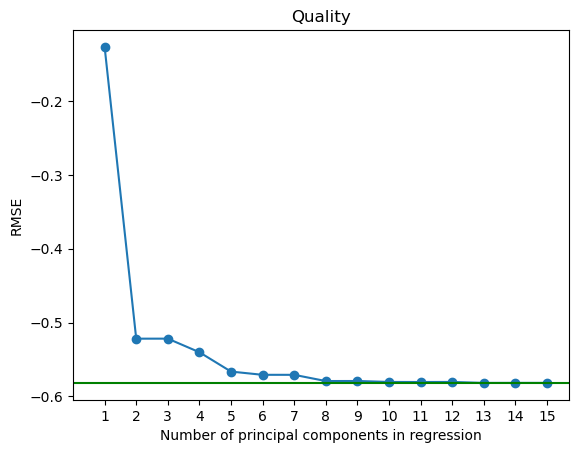

In [122]:
# Create empty list to store RMSE for each iteration
rmse_list = []

# Loop through different count of principal components for linear regression
for i in range(1, X_train_pc.shape[1]+1):
    rmse_score = -1 * cross_val_score(lin_reg, 
                                      X_train_pc[:,:i], # Use first k principal components
                                      y_train, 
                                      cv=cv, 
                                      scoring='r2').mean()
                                      #scoring='neg_root_mean_squared_error').mean()
    rmse_list.append(rmse_score)
    
# Visual analysis - plot RMSE vs count of principal components used
plt.plot(rmse_list, '-o')
plt.xlabel('Number of principal components in regression')
plt.ylabel('RMSE')
plt.title('Quality')
plt.xlim(xmin=-1);
plt.xticks(np.arange(X_train_pc.shape[1]), np.arange(1, X_train_pc.shape[1]+1))
plt.axhline(y=lr_score_train, color='g', linestyle='-');
plt.show()

In [125]:
# Visually determine optimal number of principal components
best_pc_num = 9

# Train model with first 9 principal components
lin_reg_pc = LinearRegression().fit(X_train_pc[:,:best_pc_num], y_train)

# Get cross-validation RMSE (train set)
pcr_score_train = -1 * cross_val_score(lin_reg_pc, 
                                       X_train_pc[:,:best_pc_num], 
                                       y_train, 
                                       cv=cv, 
                                       scoring='neg_root_mean_squared_error').mean()

# Train model on training set
lin_reg_pc = LinearRegression().fit(X_train_pc[:,:best_pc_num], y_train)

# Get first 9 principal components of test set
X_test_pc = pca.transform(X_test)[:,:best_pc_num]

# Predict on test data
preds = lin_reg_pc.predict(X_test_pc)
pcr_score_test = mean_squared_error(y_test, preds, squared=False)

pcr_score_test

45.32723627263053

* Partial Least Squares

In [242]:
from sklearn.cross_decomposition import PLSRegression
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

mse = []
n = len(X)

# Calculate MSE with only the intercept
score = -1*model_selection.cross_val_score(PLSRegression(n_components=1),
           np.ones((n,1)), y, cv=cv, scoring='neg_mean_squared_error').mean()    
mse.append(score)

# Calculate MSE using cross-validation, adding one component at a time
for i in np.arange(1, 6):
    pls = PLSRegression(n_components=i)
    score = -1*model_selection.cross_val_score(pls, scale(X), y, cv=cv,
               scoring='neg_mean_squared_error').mean()
    mse.append(score)

[nan,
 2141.3181105516387,
 2010.2901754310037,
 2002.3534054624843,
 2001.2567423694306,
 2001.6940520246558]

* RandomForestRegressor

In [137]:
reg = ensemble.RandomForestRegressor(n_estimators=100,  criterion='squared_error', max_depth=None, min_samples_split=2)
reg.fit(X_train, y_train)  
predictions = reg.predict(X_test)
r2 = r2_score(y_test, predictions) 
mse = mean_absolute_error( y_test, predictions)
r2

0.6255486380581559

# Pipeline and GridSearch

In [33]:
fs = SelectingEDAFeatures()
FEATS = fs.eda_features()

In [34]:
FEATS

['op1',
 'op2',
 'sensor2',
 'sensor3',
 'sensor4',
 'sensor7',
 'sensor11',
 'sensor12',
 'sensor14',
 'sensor15',
 'sensor17',
 'sensor20',
 'sensor21']

## Pipe

In [123]:
def regressions_helper():
    ## place holder for regresson models 
    #linear model
        #SGDRegressor  
        #OrthogonalMatchingPursuit  
        # BayesianRidge 
        #LinearRegression  
        #LassoLars 
        #Ridge 
        #LogisticRegression 
        #LinearRegression
        #ARDRegression  
        #ElasticNet
        #Lasso 
        #SVR 
        #PassiveAggressiveRegressor   

    # ensemble 
        #GradientBoostingRegressor
        #RandomForestRegressor

    # tree 
        # DecisionTreeRegressor

    # cross decomposition 
        #cross_decomposition. PLSRegression

    # kernel_ridge.KernelRidge
        # kernel_ridge.KernelRidge

    # catboost    
        #catboost.CatBoostRegressor  

    linear_reg = linear_model.LinearRegression(fit_intercept=True,  n_jobs=None, positive=False) 
    #n_jobs: 1 cpu, -1 all cpus, positive: if true then coeff will be >0 (only for dense arrays). #normalize can be set to true. fit_intercept when True: will be normalized
    #  fit_intercept=True, normalize='deprecated', copy_X=True, n_jobs=None, positive=False
    
    lassor_lars = linear_model.LassoLars(alpha=1.0,  fit_intercept=True, verbose=False, normalize='deprecated', precompute='auto', max_iter=500)
    # Least Angle Regression: lars.  least-angle regression (LARS) is an algorithm for fitting linear regression models to high-dimensional data
    # alpha: Constant that multiplies the penalty term. Defaults to 1.0. alpha = 0 is equivalent to an ordinary least square
    # alpha=1.0, *, fit_intercept=True, verbose=False, normalize='deprecated', precompute='auto', 
    #max_iter=500, eps=2.220446049250313e-16, copy_X=True, fit_path=True, positive=False, jitter=None, random_state=None
    
    ridge = linear_model.Ridge(alpha = 0.5)
    # alpha: ridge regulation. the lambda 
    # solver{'auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs'}, default='auto' 
    # alpha=1.0, *, fit_intercept=True, normalize='deprecated', copy_X=True, max_iter=None, tol=0.001, solver='auto', positive=False, random_state=None
     
    logit = linear_model.LogisticRegression(penalty='elasticnet', l1_ratio = 0.5)
    # penalty: 'l1', 'l2', 'elasticnet'  l1_ratio: only when penalty='elasticnet'
    # penalty='l2', *, dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, 
    #random_state=None, solver='lbfgs', max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None
    
    
    lr = linear_model.LinearRegression(fit_intercept=True, positive=False)
    # positive: make coef to be positive

    baysesain_ard = linear_model.ARDRegression(fit_intercept=True)
    #ARD Automatic Relevance Determination Regression
    # Bayesian ARD. Fit the weights of a regression model, using an ARD prior. ard Automatic Relevance Determination Regression
    # n_iter=300, tol=0.001, alpha_1=1e-06, alpha_2=1e-06, lambda_1=1e-06, lambda_2=1e-06, compute_score=False, 
    #threshold_lambda=10000.0, fit_intercept=True, normalize='deprecated', copy_X=True, verbose=False
    
    bay_ridge = linear_model.BayesianRidge()
    # Bayesian ridge regression

    elastic = linear_model.ElasticNet(alpha=1.0, l1_ratio=0.5)
    # ElasticNet

    lasso = linear_model.Lasso(alpha=1.0,  fit_intercept=True)
    # Lasso 

    svr = svm.SVR(kernel='rbf', degree=3, gamma='scale')
    # kernel{'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'}

    twee = linear_model.TweedieRegressor(alpha=1.0, fit_intercept=True, link='auto', max_iter=500)
    # Generalized Linear Model with a Tweedie distribution
    # power=0.0, alpha=1.0, fit_intercept=True, link='auto', max_iter=100, tol=0.0001, warm_start=False, verbose=0
    # power is for distribution. 0 : normal
    
    omp = linear_model.OrthogonalMatchingPursuit(fit_intercept=True)
    # Orthogonal Matching Pursuit model (OMP)
    # n_nonzero_coefs=None, tol=None, fit_intercept=True, normalize='deprecated', precompute='auto'
    # n_nonzero_coefs: 
    
    sgd = linear_model.SGDRegressor(loss='squared_error',  penalty='l2', alpha=0.0001, l1_ratio=0.15)
    # loss='squared_error', *, penalty='l2', alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=1000, 
    # tol=0.001, shuffle=True, verbose=0, epsilon=0.1, random_state=None, learning_rate='invscaling', eta0=0.01, power_t=0.25, early_stopping=False, validation_fraction=0.1, n_iter_no_change=5, warm_start=False, average=False
    
    pag = linear_model.PassiveAggressiveRegressor(max_iter = 100)
    # Passive Aggressive Regressor.
    # *, C=1.0, fit_intercept=True, max_iter=1000, tol=0.001, early_stopping=False, validation_fraction=0.1, n_iter_no_change=5, shuffle=True, verbose=0, 
    #loss='epsilon_insensitive', epsilon=0.1, random_state=None, warm_start=False, average=False
    
    en_gbr = ensemble.GradientBoostingRegressor(loss='squared_error', learning_rate=0.1, n_estimators=100) 
    #Gradient Boosting for regression.
    #  loss='squared_error', learning_rate=0.1, n_estimators=100, subsample=1.0, criterion='friedman_mse', min_samples_split=2, min_samples_leaf=1,
    # min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_decrease=0.0, init=None, random_state=None, 
    # max_features=None, alpha=0.9, verbose=0, max_leaf_nodes=None, warm_start=False, validation_fraction=0.1, n_iter_no_change=None, tol=0.0001, ccp_alpha=0.0

    en_rf = ensemble.RandomForestRegressor(n_estimators=100,  criterion='squared_error')
    # ensemble
    # n_estimators=100, *, criterion='squared_error', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=1.0, 
    # max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, ccp_alpha=0.0, max_samples=None

    tree_reg = tree.DecisionTreeRegressor(criterion='squared_error', splitter='best')
    # A decision tree regressor.

    pls = cross_decomposition.PLSRegression()
    # Partial least squares regression PLSRegression, with multivariate response, a.k.a. PLS2

    kernel_ridge = kernel_ridge.KernelRidge(kernel='linear', gamma=None, degree=3)
    # Kernel ridge regression.
    #alpha=1, *, kernel='linear', gamma=None, degree=3, coef0=1, kernel_params=None
    # alpha: regulation strength
    
    cat_reg = catboost.CatBoostRegressor(loss_function="RMSE" )
    # CatBoostRegressor
    #https://catboost.ai/en/docs/concepts/parameter-tuning
    
    lgbm_reg = lightgbm.LGBMRegressor(boosting_type='gbdt', num_leaves=31, max_depth=-1, learning_rate=0.1, n_estimators=100)
    # LGBMRegressor
    # boosting_type='gbdt', num_leaves=31, max_depth=-1, learning_rate=0.1, n_estimators=100, subsample_for_bin=200000, objective=None, 
    # class_weight=None, min_split_gain=0.0, min_child_weight=0.001, min_child_samples=20, subsample=1.0, subsample_freq=0, colsample_bytree=1.0,
    # reg_alpha=0.0, reg_lambda=0.0, random_state=None, n_jobs=None, importance_type='split', **kwargs

In [224]:
fs = SelectingEDAFeatures()
FEATS = fs.eda_features()

In [36]:
def prepare(random_state = 123, use_test_set = True):
    tmp = DF_TRAIN.copy()
    X = tmp[FEATS] 
    y = tmp.pop("rul") 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=random_state)
    
    if use_test_set:
        X_test = DF_TEST.copy()
        X_test = X_test.drop('cycle', axis=1).groupby('id').last().copy().reset_index()# get last row of each engine 
        y_test = X_test['remaining_rul'].copy()
        
    return X_train, X_test, y_train, y_test


In [37]:

X_train, X_test, y_train, y_test = prepare()

def pipeline_gridsearch():
    """
        doc: 
        grid search in pipelines
    """
    names = [  "linear_reg", #1 
    "lassor_lars", #2
    "ridge", #3 
    "logit", #4 
    "ard", #5 
    "bayesian_ridge",  #6 
    "elastic", #7 
    "lasso", #8 
    "svr", #9 very slow
    "twee", #10
    "omp", #11 
    "sgd", #12 
    "pag", #13 
    "en_gbr", #14 
    "en_rf", #15 
    "tree_reg", #16 
    #"pls", #17 
    "kernel_ridge", #17
    "cat_reg", #18
    "lgbm_reg", #19
    ]

    regressors = [ 
     linear_model.LinearRegression(), #1
     linear_model.LassoLars(),  #2
     linear_model.Ridge(), #3
     linear_model.LogisticRegression(),  #4
     linear_model.ARDRegression(), #5
     linear_model.BayesianRidge(), #6
     linear_model.ElasticNet(), #7
     linear_model.Lasso(), #8
     svm.SVR(), #9 very slow
     linear_model.TweedieRegressor(), #10
     linear_model.OrthogonalMatchingPursuit(), #11
     linear_model.SGDRegressor(), #12
     linear_model.PassiveAggressiveRegressor(), #13
     ensemble.GradientBoostingRegressor(), #14
     ensemble.RandomForestRegressor(), #15 very slow
     tree.DecisionTreeRegressor(), #16
     #cross_decomposition.PLSRegression(), #
     kernel_ridge.KernelRidge(), #17
     catboost.CatBoostRegressor(), #8
     lightgbm.LGBMRegressor()  #19
    ]

    parameters = [ 
                  {'fit_intercept': [True], "positive":[True]},  #1
                  {'fit_intercept': [True,False], "positive": [True, False], "alpha": [0, 1.0]},  #alpha: 0  is equal to ols  #2
                  {'fit_intercept': [True,False], "positive": [True, False], "solver": ["auto", "svd", "cholesky", "lsqr", "sag", "lbfgs"]},  #alpha: 0  is equal to ols  #3
                  {"penalty": ["l2", "l1", "elasticnet"],  'fit_intercept': [True,False],  "solver": ["auto", "svd", "cholesky", "lsqr", "sag", "lbfgs"]},  #alpha: 0  is equal to ols   #4
                  {'fit_intercept': [True,False], "n_iter":[200, 500] },   #5
                  {'fit_intercept': [True,False],   "n_iter":[200, 300, 400]},   #6
                  {'alpha':[0.2, 0.5, 1.0], "l1_ratio": [0.1, 0.5, 0.8],  "max_iter":[1000, 400]},   #7
                  {'alpha':[0.2, 0.5, 1.0],  "max_iter":[1000, 400]},   #8
                  {'kernel':['linear'],  "gamma":["auto", "scale"]},   #9 linear’, ‘poly’, ‘rbf’, ‘sigmoid
                  {'power':[0, 3] },   #10
                  {'n_nonzero_coefs':[None, 5, 14] }, #11
                  {'loss':["squared_error","huber","epsilon_insensitive"], "penalty": ["l2","l1","elasticnet"], "l1_ratio":[0.15, 0.5]},  #12
                  {'C':[1.0, 0.5], "early_stopping":[True, False]}, #13
                  {'loss':['squared_error', 'absolute_error',  'huber'] }, #14
                  {'criterion':['squared_error', 'absolute_error', 'poisson'], "n_estimators":[100, 200] }, #15
                  {'criterion':['squared_error', 'absolute_error',  'poisson'] },  #16
                  {'alpha':[1.0, 0.8], "kernel": ["linear"]},#17
                  {'loss_function':["RMSE"], 'iterations': [100, 150, 200],#18
                    'learning_rate': [0.03, 0.1],
                    'depth': [2, 4, 6, 8],
                    'l2_leaf_reg': [0.2, 0.5, 1, 3]}, 
                  {'learning_rate':[0.005, 0.10], "feature_fraction": [0.5, 0.9, 1.0], "boosting_type": ["gbdt", "dart"] }, #19
                   ] 

    processed = [ ]  
    history = {} 
    for  name, classifier, params in  zip(names, regressors, parameters): 
        #if name   in ["svr", "en_rf"]: ## not to proceed. too slow
        if name not in [   "cat_reg", "lgbm_reg"]:
            continue  
        if name in processed:
            continue 
        if name in history:
            continue 
        pipe=Pipeline([(name, classifier)])  
        params = {name+"__"+k: v for k, v in params.items()} # by convention 约定俗成
        gs_clf = GridSearchCV(pipe, param_grid=params, n_jobs=-1, scoring="r2" )
        clf = gs_clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        history[name] = {}
        history[name]["score"] = score 
        history[name]["regressor"] = gs_clf
       
        processed.append(name)
    return history, processed

In [41]:
if 22 == 22:
    history, processed = pipeline_gridsearch()

0:	learn: 67.5885317	total: 163ms	remaining: 32.4s
1:	learn: 66.4882233	total: 180ms	remaining: 17.8s
2:	learn: 65.4214333	total: 193ms	remaining: 12.7s
3:	learn: 64.3737333	total: 218ms	remaining: 10.7s
4:	learn: 63.4076493	total: 234ms	remaining: 9.11s
5:	learn: 62.4566425	total: 248ms	remaining: 8.01s
6:	learn: 61.5483551	total: 267ms	remaining: 7.36s
7:	learn: 60.6755802	total: 301ms	remaining: 7.21s
8:	learn: 59.8192118	total: 316ms	remaining: 6.71s
9:	learn: 59.0147616	total: 332ms	remaining: 6.32s
10:	learn: 58.2286089	total: 361ms	remaining: 6.21s
11:	learn: 57.5008897	total: 377ms	remaining: 5.91s
12:	learn: 56.8025053	total: 396ms	remaining: 5.69s
13:	learn: 56.1104818	total: 420ms	remaining: 5.58s
14:	learn: 55.4387380	total: 437ms	remaining: 5.39s
15:	learn: 54.7930134	total: 453ms	remaining: 5.21s
16:	learn: 54.1829548	total: 474ms	remaining: 5.1s
17:	learn: 53.5960048	total: 495ms	remaining: 5s
18:	learn: 53.0381669	total: 510ms	remaining: 4.86s
19:	learn: 52.5008418	tota

CatBoostError: Bad value for num_feature[non_default_doc_idx=0,feature_idx=25]="FD001": Cannot convert 'b'FD001'' to float

In [246]:
best_scores = {}
best_estimators = {}
for k,v in history.items():
    best_scores[k] = history[k]["regressor"].best_score_
    best_estimators[k] = history[k]["regressor"].best_estimator_.get_params() 
 

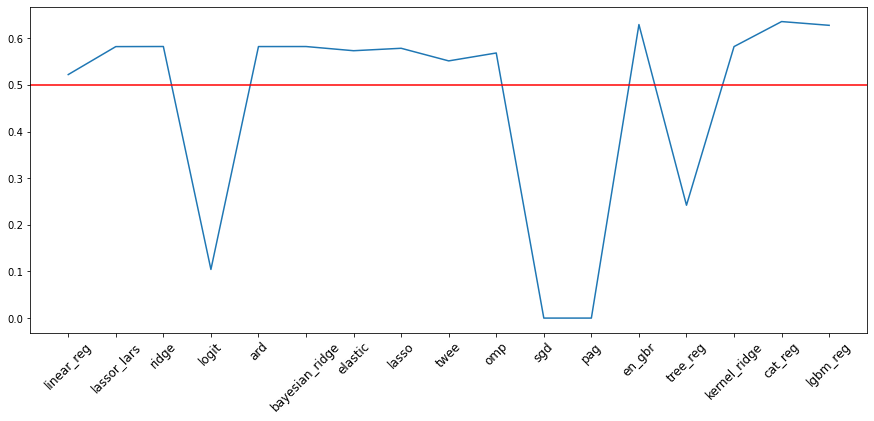

In [175]:
best = {k: v if v>0 else 0 for k,v in best_scores.items()}

plt.figure(figsize=(15,6))

plt.plot(best.keys(), best.values())
plt.xticks(rotation = 45, fontsize=12)
plt.axhline(y = 0.5, color = 'r', linestyle = '-')
plt.show()    